# Neural Network model to identify yoga poses

This notebook explores model approaches for an optimal classification of yoga poses.

## Imports

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score


from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, LeakyReLU

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

## Data Preprocessing

First, we download import the pose data into the notebook. For the tryout, we started out without visibility and presence parameters, only using coordinates. This of course can be changed at any time. We a currently in the phase of trying out what would work best for the model accuracy.

In [42]:
df = pd.read_csv('pose_landmark_data_10.csv')
cols_to_drop = [col for col in df.columns if col.endswith('visibility') or col.endswith('presence')]
df = df.drop(columns=cols_to_drop)

We then split the data into independent variables (X) and dependent variables (y). The validation split can be either done manually here (currently executed option) or within the model fitting with the data. As described below, the results are a lot better with the validation split within the model fitting (how it is not currently done). This should not be the case and needs to investigated further.



Afterwards, we transform the targets into number values, scale the features, and OneHotEncode the targets.

In [52]:
X = df.iloc[:, :len(df.columns)-1]
y = df['pose']



X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=11,
                                                    stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2,
                                                  random_state=12,
                                                  stratify=y_train)



numdict_y = {label: idx for idx, label in enumerate(np.unique(y))}
y_train_numerical = np.array([numdict_y[label] for label in y_train])
y_test_numerical = np.array([numdict_y[label] for label in y_test])
y_val_numerical = np.array([numdict_y[label] for label in y_val])



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)



y_train_encoded = to_categorical(y_train_numerical)
y_test_encoded = to_categorical(y_test_numerical)
y_val_encoded = to_categorical(y_val_numerical)


## Model Setup

In [49]:

def model_init():
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(len(numdict_y), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = model_init()

print(model.summary())


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 128)               12800     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 10)                650       
                                                                 
Total params: 25866 (101.04 KB)
Trainable params: 2586

## Model Fitting and Testing

Here fit the model on the train data. For validation, we have two options: 

1. We create the validation data manually. The advantage is that we can stratify the split, meaning keeping it proportionally equivalent amongs targets, no matter the size of the data points for each (which fluctuata a lot).This is how it is currently done. The results are surprisingly worse than with option 2.

2. We can create a direct validation split within fitting the model with validation_split. This cuts off the lower X% number given. The results are a lot better. While therefore theoretically preferable, this should not be the case and needs to investigated further.

Restoring model weights from the end of the best epoch: 2.
Epoch 6: early stopping


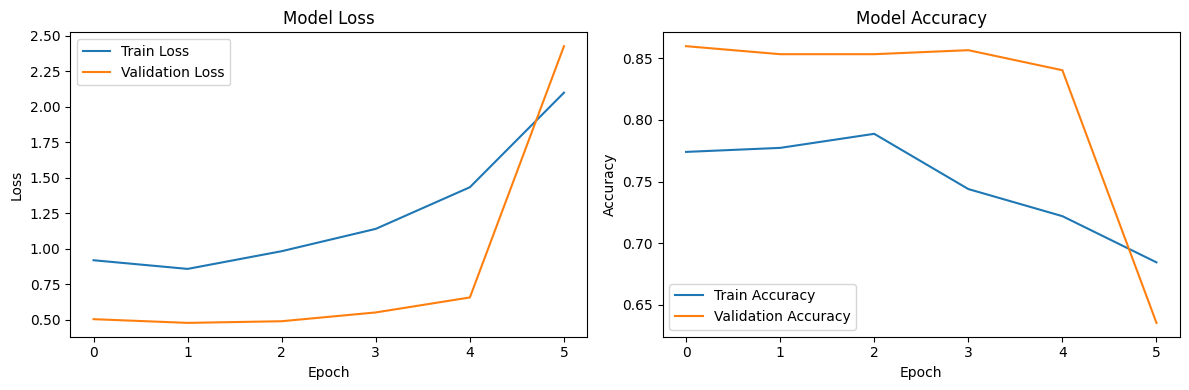

21/21 [==============================] - 0s 9ms/step - loss: 0.6231 - accuracy: 0.8371
Test Accuracy: 83.71%
Test Loss: 0.6231149435043335


In [53]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Assuming 'model' is already defined and compiled

es = EarlyStopping(
    monitor="val_loss",
    patience=4,
    verbose=1,
    restore_best_weights=True,
)

history = model.fit(
    X_train_scaled,
    y_train_encoded,
    epochs=50,
    validation_data=(X_val_scaled, y_val_encoded),
    verbose=0,
    callbacks=[es]
)

def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

results = model.evaluate(X_test_scaled, y_test_encoded, verbose=1)
print(f'Test Accuracy: {results[1]*100:.2f}%')
print(f'Test Loss: {results[0]}')
